In [ ]:
%pip install pdfminer.six
%pip install pdfplumber
%pip install numpy pandas
%pip install textdistance
%pip install regex
%pip install strictyaml


In [9]:
%pip install pyyaml

   ---------------------------------------- 0.0/138.7 kB ? eta -:--:--
   -- ------------------------------------- 10.2/138.7 kB ? eta -:--:--
   ----------- --------------------------- 41.0/138.7 kB 653.6 kB/s eta 0:00:01
   ---------------------------------------- 138.7/138.7 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure
# To extract text from tables in PDF
import pdfplumber
import numpy as np
import pandas as pd
from pathlib import Path
from typing import List, Optional, Iterable, Dict, Tuple
import regex
from textdistance import hamming
import strictyaml 
import yaml

In [5]:
from io import StringIO

from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser

In [138]:
class pdf_data():
    def __init__(self, orig_filepath: str | Path, ocr_filepath: str | Path, config: str | Path) -> None:
        self.orig_filepath = orig_filepath
        self.ocr_filepath = ocr_filepath
        self.config = config     

    def get_text_containers(self, pages: Optional[Iterable[int]] = None) -> pd.DataFrame:
        text_dict = dict(page=[], y_bottom=[], y_top=[], x_left=[], x_right=[], width=[], text=[],)
        for page_idx, page_layout in enumerate(extract_pages(self.ocr_filepath)):
            for el_idx, element in enumerate(page_layout):
                if isinstance(element, LTTextContainer):
                    text_dict['page'].append(page_idx)
                    text_dict['y_bottom'].append(element.y0)
                    text_dict['y_top'].append(element.y1)
                    text_dict['x_left'].append(element.x0)
                    text_dict['x_right'].append(element.x1)
                    text_dict['width'].append(element.width)
                    text_dict['text'].append(element.get_text().lower())
                elif isinstance(element, LTRect):
                    print(f'page = {page_idx}, ypos={element.y0}, type={type(element)}')
                else:
                    print(f'page = {page_idx}, ypos={element.y0}, type={type(element)}')

        self.text_df = pd.DataFrame(text_dict)
        self.text_df['norm_y_top']    = self.text_df['page'] + ((page_layout.height - self.text_df['y_top'   ]) / page_layout.height)
        self.text_df['norm_y_bottom'] = self.text_df['page'] + ((page_layout.height - self.text_df['y_bottom']) / page_layout.height)
        # y_min, y_max = self.text_df['y_bottom'].min(), self.text_df['y_top'].max()
        # self.text_df['norm_y_top']    = self.text_df['page'] + ((y_max - self.text_df['y_top'   ]) / (y_max - y_min))
        # self.text_df['norm_y_bottom'] = self.text_df['page'] + ((y_max - self.text_df['y_bottom']) / (y_max - y_min))
        # self.text_df['norm_y_top']    = self.text_df['page'] + ((self.text_df['y_bottom'] - y_min) / y_max)

        self.text_df.sort_values(by='norm_y_top', inplace=True, ignore_index=True, ascending=True)


    def get_section_headers(self):
        with open(self.config, 'r') as file:
            self.config_data = yaml.safe_load(file) 
        
        self.sections = dict()
        for header in self.config_data['section_headers']:
            self.sections[header] = dict(bounds = pd.DataFrame())

    def get_section_bounds(self):

        self.get_section_headers()

        # detect start and end of sections
        prev_section_info = dict(header=None, df_row=None)
        prev_page = 0
        for row_idx, text_data in self.text_df.iterrows():
            detected_section = None
            for header in self.sections.keys():
                match = regex.search(f'{header}{{s<=3,i<=3,d<=3}}', text_data['text'], regex.BESTMATCH)    
                if match is not None:
                    detected_section = header
                    break

            if text_data['page'] > prev_page or detected_section is not None:
                if prev_section_info['header'] is not None:   # store end of sections
                    prev_df_idx = self.sections[prev_section_info['header']]['bounds'].index[-1] 
                    prev_bottom = prev_page+0.9999 if (text_data['page'] > prev_page) else text_data['norm_y_top'] 
                    self.sections[prev_section_info['header']]['bounds'].loc[prev_df_idx, ['y_bottom',]] = [prev_bottom]
                # store start of sections
                top = text_data['page'] if (text_data['page'] > prev_page) else text_data['norm_y_top']
                tmp_df = pd.DataFrame(data    = zip([top], [np.nan],),
                                      columns = ['y_top', 'y_bottom',],)
                header = detected_section
                self.sections[header]['bounds'] = pd.concat((self.sections[header]['bounds'], tmp_df), ignore_index=True)
                prev_section_info['header'] = header
                if text_data['page'] > prev_page:
                    prev_page+=1
            prev_section_info['df_row'] = row_idx
        
        # store end of final section
        prev_y_bottom = self.text_df.loc[prev_section_info['df_row'], 'norm_y_bottom']
        prev_df_idx = self.sections[prev_section_info['header']]['bounds'].index[-1] 
        self.sections[prev_section_info['header']]['bounds'].loc[prev_df_idx, ['y_bottom',]] = [np.ceil(prev_y_bottom),]
    def extract_table(self, subsection_bounds):
        
        page_num = int(np.floor(subsection_bounds['y_top'])) 

        # Open the pdf file
        pdf = pdfplumber.open(self.orig_filepath)
        # Find the examined page
        table_page = pdf.pages[page_num]
        # table_crop = table_page.within_bbox((0, 35, table_page.width, 65))
        table_crop = table_page.within_bbox((               0, (subsection_bounds['y_top'   ]-page_num)*table_page.height, 
                                             table_page.width, (subsection_bounds['y_bottom']-page_num)*table_page.height))
        # Extract the appropriate table
        table = table_crop.extract_table()
        print((subsection_bounds['y_top'   ]-page_num)*table_page.height, (subsection_bounds['y_bottom']-page_num)*table_page.height, table)

    def get_text_from_rect_element(self, page_num, element):
        # Open the pdf file
        pdf = pdfplumber.open(self.ocr_filepath)
        # Find the examined page
        table_page = pdf.pages[page_num]   
        table_crop = table_page.within_bbox(element.bbox)
        text = table_crop.extract_text()
        return text   

    def extract_data_by_section(self): #TODO
        for section_header, section_dict in self.sections.items():
            for sub_idx, subsection_bounds in section_dict['bounds'].iterrows():
                try:
                    self.extract_table(subsection_bounds)
                except:
                    mask = (self.text_df['norm_y_top'] > subsection_bounds['y_top']) & \
                        (self.text_df['norm_y_bottom'] < subsection_bounds['y_bottom']) 
                    subsect_df = self.text_df.loc[mask, :]
                    for l_idx, line in subsect_df.iterrows():
                        print(line['text'].split(' '))

    def store_section_data(self, section_header): #TODO
        self.identify_section_structure(section_header)

    def print_text(self):
        max_x = 0
        for page_text in self.text_containers:
            for text_container in page_text:
                if text_container.x1 > max_x:
                    max_x = text_container.x1
        for page_num, page_text in enumerate(self.text_containers):
            print('###############################################')
            print(f'Page {page_num}')
            print('###############################################') 
            for text_container in page_text:  
                text = text_container.get_text()
                # print(f'{text_container.y0} to {text_container.y1}', text)
                print(text_container.y1, text_container.y0, text)


class exhibit_data(pdf_data):
    def __init__(self, orig_filepath: str | Path, ocr_filepath: str | Path,  config: str | Path) -> None:
        super().__init__(orig_filepath, ocr_filepath, config)

    def get_exhibit_name(self):
        for text_container in self.text_containers[0]:
            text = text_container.get_text()
            if 'exhibit' in text.lower():
                pattern = regex.compile(r'^\s+')
                exhibit = pattern.sub('', text.lower().replace('exhibit', '').replace('\n', ''))
                self.exhibit = exhibit
    
    def get_ground_space_requirements(self, keyphrases: List[str]):
        for page_text in self.text_containers:
            examine_text  = False
            get_next_line = True
            line_iter = iter(page_text)
            while get_next_line:
                text_container = line_iter.__next__()
                text = text_container.get_text().lower()
                if examine_text:
                    split_text = text.split(' ')
                    if any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                            or hamming.normalized_similarity(t, 'specifications') > 0.75
                            for t in split_text]):
                        get_next_line = False
                    else:
                        for key in keyphrases:
                            pattern = fr'((?<={key})\w+)'
                            value = regex.findall(f'{pattern}{{e<=3}}', text, regex.BESTMATCH)
                            print(value)
                # elif any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                #           or hamming.normalized_similarity(t, 'specifications') > 0.75
                #             for t in split_text])::

# fuzzy_pattern = f'({pattern}){{e<=3}}'
# text = 'I went to the doctor on 7022-O3-I6.'

# match = regex.search(fuzzy_pattern, text, regex.BESTMATCH)
# match.groupdict()

                else:
                    if hamming.normalized_similarity(text.lower(), 'ground space requirements') > 0.75:
                        examine_text = True
    
    def get_equipment_specifications(self):
        for page_text in self.text_containers:
            examine_text  = False
            get_next_line = True
            line_iter = iter(page_text)
            while get_next_line:
                text_container = line_iter.__next__()
                text = text_container.get_text().lower()
                if examine_text:
                    split_text = text.split(' ')
                    if any([   hamming.normalized_similarity(t, 'requirements')   > 0.75 
                            or hamming.normalized_similarity(t, 'specifications') > 0.75
                            for t in split_text]):
                        get_next_line = False

                
                

In [139]:
new_ocr_pdf_path  = Path('amendments/New_Exhibit_Redacted_OCR_new.pdf')
new_orig_pdf_path = Path('amendments/New_Exhibit_Redacted.pdf')
old_ocr_pdf_path  = Path('amendments/Old_Exhibit_Redacted_OCR_new.pdf')
old_orig_pdf_path = Path('amendments/Old_Exhibit_Redacted.pdf')

config_path = Path(r'C:\Users\Dalton\Documents\personal_records\apex_consulting\materials_and_amendments_OCR\configs\atc_config.yaml')


In [140]:
new_exhibit = exhibit_data(new_orig_pdf_path, new_ocr_pdf_path, config_path)
new_exhibit.get_text_containers()
new_exhibit.get_section_bounds()

for key in new_exhibit.sections.keys():
    print(f'\n{key}')
    print(new_exhibit.sections[key]['bounds'])


page = 0, ypos=-5.348e-06, type=<class 'pdfminer.layout.LTFigure'>
page = 1, ypos=-5.348e-06, type=<class 'pdfminer.layout.LTFigure'>

ground space requirements
      y_top  y_bottom
0  0.134773  0.190227

backup power requirements
      y_top  y_bottom
0  0.190227  0.218182

utility requirements
      y_top  y_bottom
0  0.218182    0.2575

transmitter & receiver specifications
    y_top  y_bottom
0  0.2575  0.285455

equipment specifications
      y_top  y_bottom
0  0.285455    0.9999
1  1.000000    2.0000


In [141]:

new_exhibit.extract_data_by_section()


106.74000000000002 150.66000000000008 None
150.66000000000008 172.79999999999995 None
172.79999999999995 203.93999999999997 None
203.93999999999997 226.07999999999993 None
226.07999999999993 791.9208 [['Type', 'GPS', 'PANEL', 'PANEL', 'TTA', 'RRU/RRH', 'RRU/RRH'], ['Manufacturer', 'Generic', 'RFS', 'CellMax', 'RFS', 'Ericsson', 'Ericsson'], ['Model #', 'GPS', 'APXVAA24_43-U-\nA20', 'CMA-B/6521/E0-6', 'ATM1900D-1CWA', 'Radio 4478 B71', 'RRU22'], ['Dimensions\nHxWxD', '12" x 9" x 6"', '96" x 24" x 8.5"', '81.1" x 7.7" x 4.8"', '8.6" x 10" x 2.6"', '15" x 13.2" x 7.4"', '20.2" x 13.2" x 6.9"'], ['Weight (lbs.)', '10.0', '101.4', '35.0', '8.4', '60.0', '52.9'], ['Location', 'Ground', 'Tower', 'Tower', 'Tower', 'Tower', 'Tower'], ['RAD Center AGL', 'N/A', "180.0'", "180.0'", "180.0'", "180.0'", "180.0'"], ['Tip Height', 'N/A', "184.0'", "183.4'", "180.4'", "180.6'", "180.8'"], ['Base Height', 'N/A', "176.0'", "176.6'", "179.6'", "179.4'", "179.2'"], ['Mount Type', 'N/A', 'Side Arm', 'Side A

In [11]:
old_exhibit = exhibit_data(old_orig_pdf_path, old_ocr_pdf_path, config_path)
old_exhibit.get_text_containers()
old_exhibit.get_section_bounds()

for key in old_exhibit.sections.keys():
    print(f'\n{key}')
    print(old_exhibit.sections[key]['bounds'])

    

page = 0, ypos=7.38e-07, type=<class 'pdfminer.layout.LTFigure'>
page = 1, ypos=-5.348e-06, type=<class 'pdfminer.layout.LTFigure'>

ground space requirements
      y_top  y_bottom  y_px_top  y_px_bottom
0  0.084788  0.184539     701.5        641.5

backup power requirements
      y_top  y_bottom  y_px_top  y_px_bottom
0  0.184539  0.235245     641.5        611.0

utility requirements
      y_top  y_bottom  y_px_top  y_px_bottom
0  0.235245  0.310889     611.0        565.5

transmitter & receiver specifications
      y_top  y_bottom  y_px_top  y_px_bottom
0  0.310889  0.360765     565.5        535.5

equipment specifications
      y_top  y_bottom  y_px_top  y_px_bottom
0  0.360765  1.013333    535.50       744.48
1  1.013333  2.000000    744.48         0.00


In [67]:
[t for t in new_exhibit.text_df.text]

['exhibit a-4\n',
 'ground space requirements\n',
 'backup power requirements\n',
 'generator: n/a\n',
 'fuel tank size (gal): n/a\n',
 'fuel tank setback (radius): n/a\n',
 'fuel type: n/a\n',
 'utility requirements\n',
 'power provided by: utility company direct\n',
 'telco/interconnect: n/a\n',
 'transmitter & receiver specifications\n',
 'type: n/a quantity: n/a tx power (watts): n/a erp power (watis): n/a\n',
 'equipment specifications\n',
 'type gps panel panel tta rru/rrh rru/rrh\n',
 'manufacturer generic rfs cellmax rfs ericsson ericsson\n',
 'model # gps apxvars 4s-u- cma-b/6521/e0-6 | atm1900d-1cwa | radio 4478 b71 rru22\n',
 'dimensions 12" x 9" x 6" 96" x 24" x 8.5" 81.1" x 7.7" x 4.8" 8.6"x 10" x 2.6" 15"x 13.2" x 7.4" | 20.2" x 13.2" x 6.9"\n',
 'weight (ibs.) 10.0 101.4 35.0 8.4 60.0 52.9\n',
 'location ground tower tower tower tower tower\n',
 "rad center agl n/a 180.0' 180.0’ 180.0’ 180.0’ 180.0’\n",
 "tip height n/a 184.0’ 183.4' 180.4' 180.6' 180.8\n",
 'base height

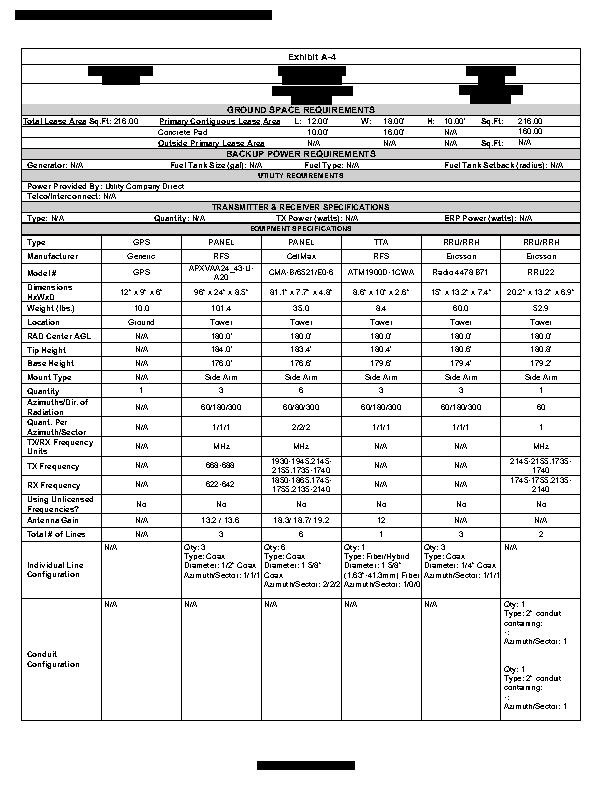

In [128]:
page_num = 0

# Open the pdf file
pdf = pdfplumber.open(new_exhibit.orig_filepath)
# Find the examined page
table_page = pdf.pages[page_num]
table_page.to_image()

AttributeError: 'PDF' object has no attribute 'extract_table'

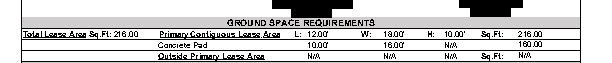

In [103]:
# table_crop = table_page.within_bbox((0, 35, table_page.width, 65))
table_crop = table_page.within_bbox((0, .11*table_page.height, table_page.width, .19*table_page.height))
tmp = table_crop.to_image()
tmp
# Extract the appropriate table
# tmp = []

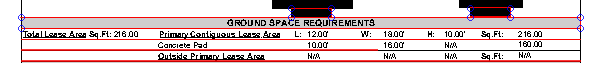

In [104]:
table_settings = {
    "vertical_strategy": "lines",
    "horizontal_strategy": "lines",
    "snap_y_tolerance": 5,
    "intersection_x_tolerance": 5,
}
tmp.reset().debug_tablefinder(table_settings)

In [110]:
table = table_crop.extract_tables(table_settings)
text = table_crop.extract_text_lines()
text[3]

{'text': 'Outside Primary Lease Area N/A N/A N/A Sq.Ft: N/A',
 'x0': 158.096,
 'top': 138.7299999999999,
 'x1': 531.7860000000001,
 'bottom': 147.39199999999994,
 'chars': [{'matrix': (1, 0, 0, 1, 158.096, 646.264),
   'fontname': 'Helvetica-Bold',
   'adv': 6.224,
   'upright': True,
   'x0': 158.096,
   'y0': 644.6080000000001,
   'x1': 164.32,
   'y1': 652.6080000000001,
   'width': 6.2239999999999895,
   'height': 8.0,
   'size': 8.0,
   'mcid': None,
   'tag': None,
   'object_type': 'char',
   'page_number': 1,
   'ncs': 'DeviceRGB',
   'text': 'O',
   'stroking_color': None,
   'stroking_pattern': None,
   'non_stroking_color': (0, 0, 0),
   'non_stroking_pattern': None,
   'top': 139.39199999999994,
   'bottom': 147.39199999999994,
   'doctop': 139.39199999999994},
  {'matrix': (1, 0, 0, 1, 164.32, 646.264),
   'fontname': 'Helvetica-Bold',
   'adv': 4.888,
   'upright': True,
   'x0': 164.32,
   'y0': 644.6080000000001,
   'x1': 169.208,
   'y1': 652.6080000000001,
   'width':

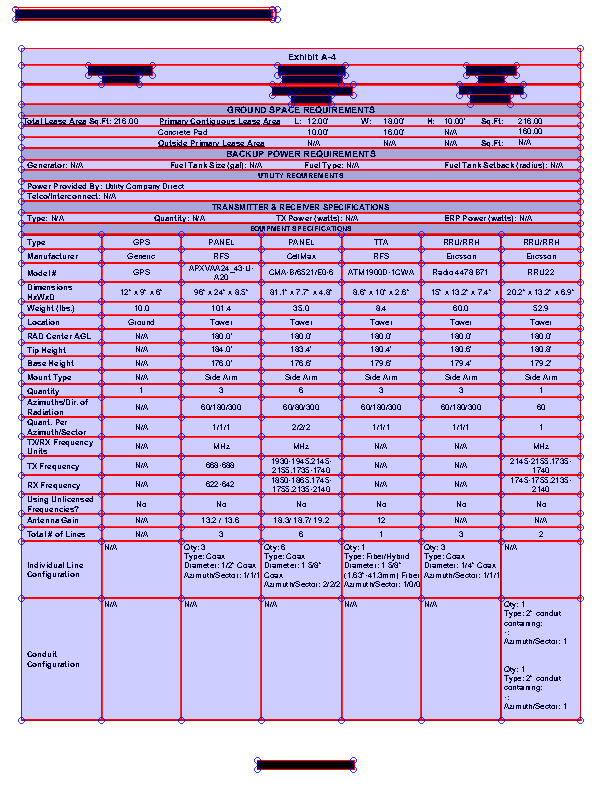

In [32]:
pdf = pdfplumber.open(original_pdf_path)
# Find the examined page
table_page = pdf.pages[0]
tmp = table_page.to_image()

# table_crop = table_page.crop((21.25, 600.272, 580.5, 687.772))
# table_crop.to_image()


In [34]:
# table_crop = table_page.within_bbox((0, 35, table_page.width, 65))
# table_crop = table_page.within_bbox()
# table_crop.to_image()
# table_crop
# Extract the appropriate table
tables = table_page.extract_tables()

In [44]:
tables[1]

[['Exhibit A-4', None, None, None, None, None, None],
 ['', None, None, None, None, None, None],
 ['', None, None, None, None, None, None],
 ['GROUND SPACE REQUIREMENTS', None, None, None, None, None, None],
 ["Total Lease Area Sq.Ft: 216.00 Primary Contiguous Lease Area L: 12.00' W: 18.00' H: 10.00' Sq.Ft: 216.00",
  None,
  None,
  None,
  None,
  None,
  None],
 ["Concrete Pad 10.00' 16.00' N/A 160.00", None, None, None, None, None, None],
 ['Outside Primary Lease Area N/A N/A N/A Sq.Ft: N/A',
  None,
  None,
  None,
  None,
  None,
  None],
 ['BACKUP POWER REQUIREMENTS', None, None, None, None, None, None],
 ['Generator: N/A Fuel Tank Size (gal): N/A Fuel Type: N/A Fuel Tank Setback (radius): N/A',
  None,
  None,
  None,
  None,
  None,
  None],
 ['UTILITY REQUIREMENTS', None, None, None, None, None, None],
 ['Power Provided By: Utility Company Direct',
  None,
  None,
  None,
  None,
  None,
  None],
 ['Telco/Interconnect: N/A', None, None, None, None, None, None],
 ['TRANSMITTER

In [ ]:
old_exhibit.get_section_bounds()
old_exhibit.store_section_data('equipment specifications')

In [13]:
old_exhibit.sections['ground space requirements']['bounds']

,y_top,y_bottom
0,0.084788,0.168745


In [30]:
old_exhibit.text_df

,page,y_bottom,y_top,x_left,x_right,width,text,norm_y_top,norm_y_bottom
0,1,722.260063,728.938064,37.161801,52.251453,15.089652,type\n,1.000000,1.017242
1,1,722.260063,728.938064,126.920802,154.376253,27.455450,dish-hp\n,1.000000,1.017242
2,1,722.260063,728.938064,194.906555,222.362005,27.455450,dish-hp\n,1.000000,1.017242
3,1,722.260063,728.938064,261.084053,295.227286,34.143233,radio/odu\n,1.000000,1.017242
4,1,722.260063,728.938064,330.229552,364.372784,34.143233,radio/odu\n,1.000000,1.017242
...,...,...,...,...,...,...,...,...,...
156,1,432.888453,439.566453,480.641907,484.355892,3.713985,0\n,1.747121,1.764363
157,1,415.822453,422.500453,476.932649,488.064823,11.132174,n/a\n,1.791183,1.808425
158,1,399.498452,406.176452,476.934133,488.066307,11.132174,n/a\n,1.833330,1.850571
159,1,384.658452,391.336452,476.934875,488.067049,11.132174,n/a\n,1.871645,1.888886


In [15]:

old_exhibit.get_text_containers()
old_exhibit.get_exhibit_name()
old_exhibit.get_ground_space_requirements(keyphrases=['lease area',  'concrete pad'])

page = 0, ypos=23.319, type=<class 'pdfminer.layout.LTFigure'>
page = 0, ypos=667.016, type=<class 'pdfminer.layout.LTLine'>
page = 0, ypos=667.016, type=<class 'pdfminer.layout.LTLine'>
page = 0, ypos=667.016, type=<class 'pdfminer.layout.LTLine'>
page = 0, ypos=667.016, type=<class 'pdfminer.layout.LTLine'>
page = 0, ypos=645.416, type=<class 'pdfminer.layout.LTLine'>


IndexError: list index out of range

In [7]:
old_exhibit.print_text()

AttributeError: 'exhibit_data' object has no attribute 'text_containers'

AttributeError: 'list_iterator' object has no attribute 'next'

In [149]:
old_exhibit.print_text()

###############################################
Page 0
###############################################
Exhibit A-3

GROUND SPACE REQUIREMENTS

Total Lease Area Sq.Ft:21600° Primary Contiquous Lease Area L:1200 W:1800 H:1000° Sq.Ft:216.00)

Concrete Pad 1000 1600 NA 160.00|

Outside Primary Lease Area NA NA NA Sq. Ft: N/A|

BACKUP POWER REQUIREMENTS

Generator: NIA Capacity(KW): N/A Fuel Tank Size(gal): N/A Fuel Type: NIA Fuel Tank Setback{radiu:

UTILITY REQUIREMENTS

Power Provided By: Utiity Company Direct

uA

Telco/nterconnect:

TRANSMITTER & RECEIVER SPECIFICATIONS

Type: N/A Quantity: NIA TX Power(watts): NIA ERP(watts): N/A

EQUIPMENT SPECIFICATIONS

Type PANEL PANEL TTA RRURRH RRURRH RRURRH
Manufacturer CellMax RFS RFS Ericsson Ericsson Ericsson
Model # CMABIGS21/E06 | APXVAA24_43-U-A20| ATM1900D-1CWA RRUZ2 RRU22 Radio 4478 B71

Dimensions HxXWxD | 81.1'x7.7'x48 | 96'x24'x85 | 86x10x26 | 202 x132x69" | 202 x132°x68" | 16'x 132 x74"

[Weight(ibs.) 350 1014 84 529 529 600
Locatio

In [ ]:
output_string = StringIO()
with open(original_pdf_path, 'rb') as in_file:
    parser = PDFParser(in_file)
    doc = PDFDocument(parser)
    rsrcmgr = PDFResourceManager()
    device = TextConverter(rsrcmgr, output_string, laparams=LAParams(line_margin=0.25))
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    for page in PDFPage.create_pages(doc):
        interpreter.process_page(page)
print(output_string.getvalue())

In [153]:
for page_layout in extract_pages(pdf_path):
    for idx, element in enumerate(page_layout):
        if isinstance(element, LTTextContainer):
            for text_line in element:
                text_line.get_text()

KeyboardInterrupt: 